In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import swifter

In [3]:
import sys
import os.path
import pandas as pd
# Local Modules
sys.path.insert(0, os.path.abspath('/scratch/horta/coronatwitter/'))
from helpers.vars import categories_coarse, types, langs, lang_names, lang_colors,\
                         nicer_words, remove_not_in_english, quint, categories_final
from helpers.plot import set_size, colors_cats
from helpers.df import get_avg

In [4]:
# Latex Configuration
import matplotlib.font_manager as font_manager
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext='ttf')

fontpath = os.path.expanduser('/dlabdata1/Roboto-Thin.ttf')
prop = font_manager.FontProperties(fname=fontpath)

params = {
    "axes.titlesize" : 14,
    'axes.labelsize': 12,
    'font.size': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': 'sans-serif',
    "font.sans-serif": "Helvetica",#prop.get_name(),
    'text.usetex': True
}

mpl.rcParams.update(params)

In [5]:
path = "/dlabdata1/gligoric/Coronatwitter/"

## Loads data

In [6]:
def get_quint(row):
    row = dict(row)
    if row["lang"] not in langs:
        return None
    followers = np.array(quint[row["lang"]]["followers"])
    retweets = np.array(quint[row["lang"]]["retweets"])
    row["quintile_followers"] = np.argmax(row["user.num_followers"] < followers)
    row["quintile_retweets"] = np.argmax(row["num_retweets"] < retweets)
    return pd.Series(row)

In [7]:
# Reads the tweets with more than 10 retweets for all 7 days
df_10_rt = pd.read_pickle(path + 'datasets/covid_stream_7_days_all_tweets_10_rt.pickle')

# Gets the maximum number of retweets per user
df_10_rt_max = df_10_rt.loc[:, ["num_retweets", "user.num_followers", "user.screen_name", "lang"]]\
                       .groupby("user.screen_name").max()

# Filters only languages of interest
df_10_rt_max = df_10_rt_max.loc[df_10_rt_max.lang.apply(lambda x: x in langs)]

# Apply a function to get quintiles
df_quintiles = df_10_rt_max.swifter.apply(lambda x: get_quint(x), axis=1)

# Deletes useless dataframes
del df_10_rt
del df_10_rt_max

df_quintiles.head(2)

,num_retweets,user.num_followers,lang,quintile_followers,quintile_retweets
user.screen_name,,,,,
00001V,15,78,ja,1,2
0000HALO4,24,156,ja,1,3


In [8]:
# this loads the annotated users and all their tweets!
df_annotated = pd.read_pickle(path + 'V2_annotated_users.pickle')
df_stream = pd.read_pickle(path + 'datasets/covid_stream_all_tweets_sampled_usersv2.pickle')

# small fix
df_stream['user.screen_name'] = df_stream['user.screen_name'].astype(str)
df_annotated['username'] = df_annotated['username'].astype(str)

# # merge the two on screen_name, merge on the annotated
df_merged = df_stream.merge(df_annotated, left_on='user.screen_name', right_on='username', 
                how = 'right')

# # gets average
df = get_avg(df_merged, categories_coarse, types)

# cleans the dataframe a bit
df = df.loc[:, ["username"] + [c for c in df.columns if c[-4:] == "_avg"]]
df = df.groupby(["username"]).max()
df["sampled"] = True

df.head(2)

,Art_avg,Business_avg,Government and Politics_avg,Healthcare_avg,Media_avg,Non-Governmental Organization_avg,Outspoken Political Supporter_avg,Porn_avg,Public Services_avg,Religion_avg,Science_avg,Sport_avg,Other_avg,Individual:Male_avg,Institution_avg,Individual: Other gender or unclear_avg,Unclear_avg,Individual:Female_avg,sampled
username,,,,,,,,,,,,,,,,,,,
000alotaibi,0.00,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.25,0.25,0.5,0.0,0.00,True
000shio71,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.00,0.00,0.0,0.5,0.25,True


In [9]:
# merge quintiles weith this dataframe
df_final = df_quintiles.merge(df, how="left", left_index=True, right_index=True).fillna(False)

# this threshold adds
for col in  [c for c in df.columns if c[-4:] == "_avg"]:
    df_final[col] = df_final[col].apply(lambda x: x >= 0.5)
    
df_final.head(2)

,num_retweets,user.num_followers,lang,quintile_followers,quintile_retweets,Art_avg,Business_avg,Government and Politics_avg,Healthcare_avg,Media_avg,...,Religion_avg,Science_avg,Sport_avg,Other_avg,Individual:Male_avg,Institution_avg,Individual: Other gender or unclear_avg,Unclear_avg,Individual:Female_avg,sampled
user.screen_name,,,,,,,,,,,,,,,,,,,,,
00001V,15,78,ja,1,2,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
0000HALO4,24,156,ja,1,3,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [10]:
# gets the mean sampled value for each quintile pair + language
df_bs = df_final.groupby(["lang", "quintile_followers", "quintile_retweets"]).sampled.mean()
df_bs = df_bs.reset_index()

# assigns weight inversely proportional to that
df_bs["w"] = 1/df_bs["sampled"] 
df_bs.drop("sampled", axis=1, inplace=True)

# merge this into our dataframe
to_merge = ["lang", "quintile_followers", "quintile_retweets"]
df_w = df_final.loc[df_final.sampled].reset_index().merge(df_bs,  how="left", left_on=to_merge, right_on=to_merge)

# removes hindi and indonesian
df_w = df_w.loc[(df_w.lang != "in") & (df_w.lang != "hi")]

df_w.head(2)

# df_w = df_w[df_w.loc[:, [c + "_avg" for c in categories_coarse[:-1]]].sum(axis=1) > 0]

,user.screen_name,num_retweets,user.num_followers,lang,quintile_followers,quintile_retweets,Art_avg,Business_avg,Government and Politics_avg,Healthcare_avg,...,Science_avg,Sport_avg,Other_avg,Individual:Male_avg,Institution_avg,Individual: Other gender or unclear_avg,Unclear_avg,Individual:Female_avg,sampled,w
0,000alotaibi,33,41439,ar,4,4,False,False,False,False,...,False,False,True,False,False,True,False,False,True,2.942308
1,000shio71,19,1156,ja,3,3,False,False,False,False,...,False,False,True,False,False,False,True,False,True,22.125000


In [11]:
df_w["Individuals_avg"] = df_w["Individual:Female_avg"] |\
                         df_w["Individual:Male_avg"] |\
                         df_w["Individual:Male_avg"] |\
                         df_w["Individual: Other gender or unclear_avg"]


In [12]:
df_w.to_pickle(path + "user_w.pkl")

In [13]:
set(df_w.lang)

{'ar', 'de', 'en', 'es', 'fr', 'it', 'ja', 'pt'}

In [14]:
df_w.groupby(["quintile_followers", "quintile_retweets", "lang"]).w.mean()\
    .reset_index()

,quintile_followers,quintile_retweets,lang,w
0,1,1,ar,3.245283
1,1,1,de,2.354167
2,1,1,en,47.097222
3,1,1,es,24.250000
4,1,1,fr,3.470588
...,...,...,...,...
195,5,5,es,43.000000
196,5,5,fr,5.100000
197,5,5,it,2.204545
198,5,5,ja,42.348485


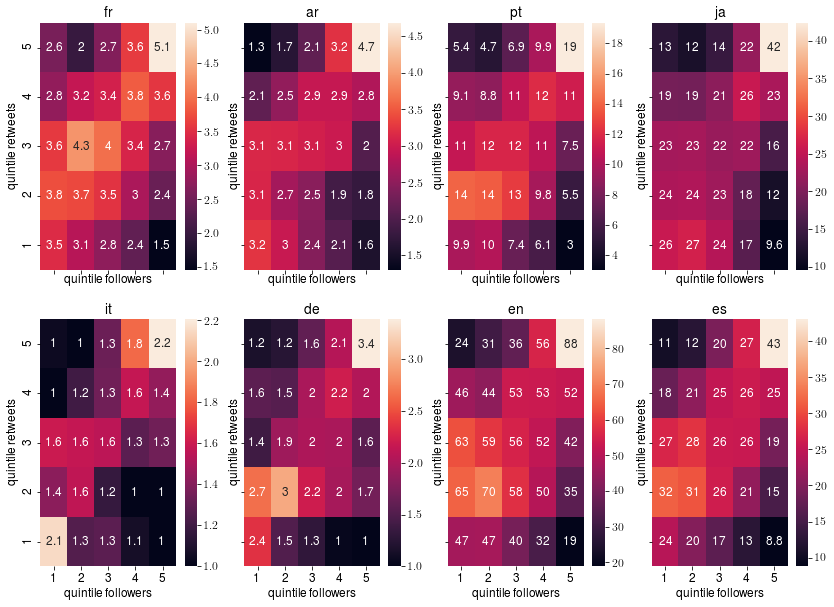

In [15]:
tmp = df_w.groupby(["quintile_followers", "quintile_retweets", "lang"]).w.mean()\
    .reset_index()

fig, axs = plt.subplots(2, 4, figsize=(14,10),  sharex=True, sharey=True)
axs = axs.flatten()
for idx, lang in enumerate(set(df_w.lang)):
    matrix = tmp[tmp.lang == lang].pivot_table("w", 'quintile_retweets', 'quintile_followers')
    sns.heatmap(data=matrix[::-1], annot=True, ax=axs[idx])
    axs[idx].set_xlabel("quintile followers")
    axs[idx].set_ylabel("quintile retweets")
    axs[idx].set_title(lang)


In [19]:
def bootstrap(df_w, c, langs, S=10):
    vals = []
    for i in range(S):
        values = []
        weights = []
        for lang in langs:
            for qf in range(1, 6):
                for qr in range(1, 6):
                    df_w_ = df_w[(df_w.lang == lang ) & 
                                 (df_w.quintile_followers == qf) &
                                 (df_w.quintile_retweets == qr)]
                    idx = np.random.choice(df_w_.index, size=(len(df_w_),))
                    values += list(df_w[c].loc[idx].values)
                    weights += list(df_w["w"].loc[idx].values)
                    
        vals.append(np.average(np.array(values), weights=np.array(weights)))
    vals = sorted(vals)
    low = vals[int(0.025 * S)]
    high = vals[int(0.975 * S)]
    mean = np.mean(vals)
    
    return (mean, low, high)

In [20]:
cat_ordered = [
'Other',
'Media',
'Art',
'Science',
'Outspoken Political Supporter',
'Government and Politics',
'Business',
'Healthcare',
'Non-Governmental Organization',
'Sport',
'Public Services',
'Porn',
'Religion'
][::-1]

Religion 0.008062964899651411 0.006103797656517312 0.012268865667085835
Porn 0.010338144055502634 0.007990222308421661 0.013407817576391666
Public Services 0.017805669729991605 0.014724574557936475 0.021313346520369654
Sport 0.02538309790084563 0.019591425183665672 0.03039369552674487
Non-Governmental Organization 0.030043253835480982 0.024434332357901756 0.03520010582531312
Healthcare 0.034098364458592094 0.02968078814383478 0.03807975235083934
Business 0.041425689870174184 0.036747428798926805 0.046743392073504725
Government and Politics 0.053040845650695466 0.04397848054570641 0.06224063100223424
Outspoken Political Supporter 0.056668001381931024 0.049401726132443646 0.061405308603919774
Science 0.06497901708511147 0.06031231788139298 0.06999216220744128
Art 0.07618446101399541 0.06879278708886748 0.08330500757615414
Media 0.153312264578981 0.13970083075199555 0.16381484861700493
Other 0.4291329462343524 0.41592072342973513 0.4449431499435306


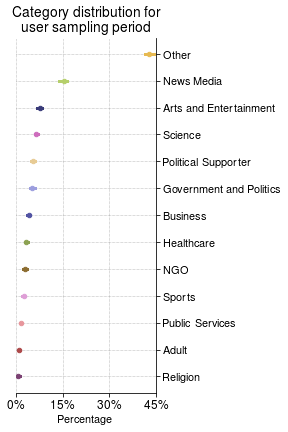

In [25]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(4, 6), constrained_layout=True)
spec = gridspec.GridSpec(ncols=8, nrows=3, figure=fig)
axs = []
axs_type = []

ax_big = (fig.add_subplot(spec[:, :]))

ax_big.spines['left'].set_visible(False)
ax_big.spines['top'].set_visible(False)

for idy, category in enumerate(cat_ordered):
    mean, low, high = bootstrap(df_w, category + "_avg", langs, S=20)
    ax_big.scatter([mean], [idy], s=20, color=colors_cats[category], zorder=4)
    ax_big.plot([low, high], [idy, idy], color=colors_cats[category], zorder=4, lw=3)
    print(category, mean, low, high)

ax_big.set_yticks(list(range(len(cat_ordered))))
ax_big.set_yticklabels([categories_final[c] for c in cat_ordered], size=11)
ax_big.set_title("Category distribution for \n user sampling period")
ax_big.set_xticks([0, .15, .30, .45])
ax_big.set_xlim([0, .45])

ax_big.yaxis.tick_right()
ax_big.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
ax_big.grid(axis="x", color='#777777', linestyle=':', linewidth=0.5)
ax_big.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
ax_big.set_xlabel('Percentage', size=11)


set_size(fig, (4, 6))
fig.savefig("../images/1B_proportions.pdf", bbox_inches="tight")

## Across languages

In [ ]:
fig = plt.figure(figsize=(14, 6), constrained_layout=True)
spec = gridspec.GridSpec(ncols=6, nrows=3, figure=fig)
axs = []
axs_type = []

for idx in range(6):
    axs.append(fig.add_subplot(spec[0, idx]))
for idx in range(6):
    axs.append(fig.add_subplot(spec[1, idx]))
for idx in range(2):
    axs_type.append(fig.add_subplot(spec[2, idx*3: (idx+1)*3]))
    

for idx, ax in enumerate(axs):
    category=categories_coarse[:-1][idx]
    
    for idy, lang in enumerate(langs):
        df_ = df_w.loc[df_w.lang == lang]
        mean, low, high = bootstrap(df_, category + "_avg", [lang], S=10)
        ax.scatter([mean], [idy], s=20, color=lang_colors[lang], edgecolors= "black", linewidth=0.5, zorder=4)
        ax.plot([low, high], [idy, idy], color=lang_colors[lang], zorder=1, lw=3)

    if idx == 0 or idx == 6:
        ax.set_yticklabels([lang_names[l] for l in langs], size=10)
    elif idx == 5 or idx == 11:
        ax.set_yticklabels([lang_names[l] for l in langs], size=10)
        ax.yaxis.tick_right()
    else:
        ax.set_yticklabels([])
        
    ax.set_yticks(list(range(len(langs))))
    ax.set_title(categories_final[category], size=11)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=1))
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    if idx >= 12:
        ax.set_xlabel("Percentage")
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_size(11)
        
        
for idx, typ in enumerate(["Individuals_avg", "Institution_avg"]):
    ax=axs_type[idx]
    
    for idy, lang in enumerate(langs):
        df_ = df_w.loc[df_w.lang == lang]
        mean, low, high = bootstrap(df_, typ, [lang], S=10)
        ax.scatter([mean], [idy], s=20, color=lang_colors[lang], edgecolors= "black", linewidth=0.5, zorder=4)
        ax.plot([low, high], [idy, idy], color=lang_colors[lang], zorder=1, lw=3)

    if idx == 0:
        ax.set_yticklabels([lang_names[l] for l in langs], size=9)
    elif idx == 1:
        ax.set_yticklabels([lang_names[l] for l in langs], size=9)
        ax.yaxis.tick_right()
    else:
        ax.set_yticklabels([])
        
    ax.set_yticks(list(range(len(langs))))
    _, max_l = ax.get_xlim()
    ax.set_xlim([0, max_l])
    ax.set_title(typ.replace("Individual:", "")\
                    .replace("_avg", "")\
                    .replace("Female", "Women")\
                    .replace("Institution", "Institutions")\
                    .replace("Male", "Men"), size=11)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=1))
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        tick.set_size(11)
    ax.set_xticks([0, .25, .50, .75])
    ax.set_xlim([0, .75])
        
set_size(fig, (14, 6))
fig.savefig("../images/S4_proportions.pdf", bbox_inches="tight")

# Alternate view

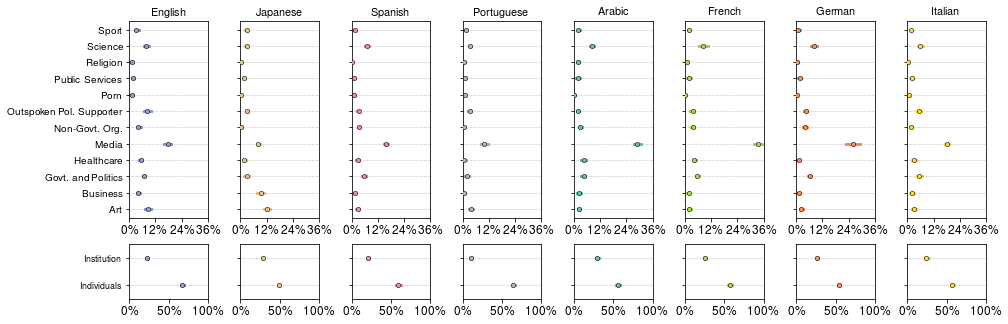

In [21]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(14, 4.5), constrained_layout=True)
spec = gridspec.GridSpec(ncols=8, nrows=3, figure=fig)
axs = []
axs_type = []

for idx in range(8):
    axs.append(fig.add_subplot(spec[0:2, idx]))

for idx in range(8):
    axs_type.append(fig.add_subplot(spec[2:3, idx]))
    

for idx, ax in enumerate(axs):
    lang = langs[idx]
    
    tmp = df_w[[c + "_avg" for c in categories_coarse[:-1]]].sum(axis=1) > 0
        
    for idy, category in enumerate(categories_coarse[:-1]):
        df_ = df_w.loc[df_w.lang == lang]
        mean, low, high = bootstrap(df_, category + "_avg", [lang], S=10)
        ax.scatter([mean], [idy], s=20, color=lang_colors[lang], edgecolors= "black", linewidth=0.5, zorder=4)
        ax.plot([low, high], [idy, idy], color=lang_colors[lang], zorder=1, lw=3)

    if idx == 0:
        ax.set_yticklabels([nicer_words(category) for category in categories_coarse[:-1]], size=10)
    else:
        ax.set_yticklabels([])
        
    ax.set_yticks(list(range(len(categories_coarse[:-1]))))
    ax.set_title(lang_names[lang], size=11)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    ax.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)
    
    ax.set_xticks([0, .12, .24, .36])
    ax.set_xlim([0, .36])
    
    ax2 = axs_type[idx]

    for idy, typ in enumerate(["Individuals_avg", "Institution_avg"]):
        df_ = df_w.loc[df_w.lang == lang]
        mean, low, high = bootstrap(df_, typ, [lang], S=10)
        ax2.scatter([mean], [idy], s=20, color=lang_colors[lang], edgecolors= "black", linewidth=0.5, zorder=4)
        ax2.plot([low, high], [idy, idy], color=lang_colors[lang], zorder=1, lw=3)
        
    
    if idx == 0:
        ax2.set_yticklabels(["Individuals", "Institution"], size=9)
    else:
        ax2.set_yticklabels([])
        
    ax2.set_yticks(list(range(2)))
    _, max_l = ax2.get_xlim()
    ax2.set_ylim([-0.5, 1.5])
    ax2.set_xticks([0, .50,  1.])
    ax2.set_xlim([0, 1])
    ax2.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1., decimals=0))
    ax2.grid(axis="y", color='#777777', linestyle=':', linewidth=0.5)

        
set_size(fig, (14, 4.5))
fig.savefig("/scratch/horta/coronatwitter/images/number_of_users_category/proportions2.pdf", bbox_inches="tight")